In [4]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [17]:
# read in data
# persona chat (PC) data
pc_prism = pd.read_csv('../pc_usr_scores', sep='\t')
pc_prism_empty = pd.read_csv('../pc_usr_prism_empty_scores', sep='\t')
pc_prism_context = pd.read_csv('../pc_usr_prism_context_scores', sep='\t')
pc_bert = pd.read_csv('../pc_usr_bert_scores', sep='\t')

# topical chat (TC) data
tc_prism = pd.read_csv('../tc_usr_scores', sep='\t')
tc_prism_empty = pd.read_csv('../tc_usr_prism_empty_scores', sep='\t')
tc_prism_context = pd.read_csv('../tc_usr_prism_context_scores', sep='\t')
tc_bert = pd.read_csv('../tc_usr_bert_scores', sep='\t')

In [18]:
print(f"pc_prism shape: {pc_prism.shape}")
print(f"pc_prism_empty shape: {pc_prism_empty.shape}")
print(f"pc_prism_context shape: {pc_prism_context.shape}")
print(f"pc_bert shape: {pc_bert.shape}")
print(f"tc_prism shape: {tc_prism.shape}")
print(f"tc_prism_empty shape: {tc_prism_empty.shape}")
print(f"tc_prism_context shape: {tc_prism_context.shape}")
print(f"tc_bert shape: {tc_bert.shape}")

pc_prism shape: (240, 12)
pc_prism_empty shape: (240, 12)
pc_prism_context shape: (240, 12)
pc_bert shape: (240, 12)
tc_prism shape: (300, 12)
tc_prism_empty shape: (300, 12)
tc_prism_context shape: (300, 12)
tc_bert shape: (300, 12)


In [19]:
# scores for all dataframes are incorrectly named 'prism_score', need to correct
pc_prism_empty = pc_prism_empty.rename(columns={'prism_score':'prism_empty_score'})
pc_prism_context = pc_prism_context.rename(columns={'prism_score':'prism_context_score'})
pc_bert = pc_bert.rename(columns={'prism_score':'bert_score'})
tc_prism_empty = tc_prism_empty.rename(columns={'prism_score':'prism_empty_score'})
tc_prism_context = tc_prism_context.rename(columns={'prism_score':'prism_context_score'})
tc_bert = tc_bert.rename(columns={'prism_score':'bert_score'})

# merge dataframes for the same dataset together
# we can merge on indices because dataset is unsorted
pc_df = pc_prism.merge(right=pc_prism_empty['prism_empty_score'], left_index=True, right_index=True)
pc_df = pc_df.merge(right=pc_prism_context['prism_context_score'], left_index=True, right_index=True)
pc_df = pc_df.merge(right=pc_bert['bert_score'], left_index=True, right_index=True)

tc_df = tc_prism.merge(right=tc_prism_empty['prism_empty_score'], left_index=True, right_index=True)
tc_df = tc_df.merge(right=tc_prism_context['prism_context_score'], left_index=True, right_index=True)
tc_df = tc_df.merge(right=tc_bert['bert_score'], left_index=True, right_index=True)

In [20]:
pc_df.head()

,context,fact,ref,cand,model,understandable,natural,maintains_context,engaging,uses_knowledge,overall,prism_score,prism_empty_score,prism_context_score,bert_score
0,hi there how are you doing this evening ?\nhi ...,your persona: i also have a dog walking busine...,ha ha i'm so shy,i know what you mean spend most nights cuddlin...,KV-MemNN,"[1, 1, 1]","[3, 3, 3]","[1, 1, 1]","[3, 3, 3]","[1, 0, 1]","[2, 2, 2]",-5.575214,-10.589826,-5.951426,0.816361
1,hi there how are you doing this evening ?\nhi ...,your persona: i also have a dog walking busine...,ha ha i'm so shy,i am a little shy but i am a little shy\n,Seq2Seq,"[1, 1, 1]","[2, 1, 2]","[3, 3, 3]","[1, 2, 2]","[0, 0, 0]","[3, 3, 3]",-3.830842,-9.470301,-5.007862,0.879631
2,hi there how are you doing this evening ?\nhi ...,your persona: i also have a dog walking busine...,ha ha i'm so shy,i am not . i am a student .\n,Language Model,"[0, 0, 1]","[2, 2, 3]","[1, 1, 1]","[1, 2, 2]","[0, 0, 0]","[2, 2, 2]",-5.240315,-8.970673,-5.508078,0.850260
3,hi there how are you doing this evening ?\nhi ...,your persona: i also have a dog walking busine...,ha ha i'm so shy,i only feel comfortable sharing my music with ...,New Human Generated,"[1, 1, 1]","[3, 3, 3]","[3, 3, 3]","[3, 3, 3]","[1, 1, 1]","[5, 5, 5]",-6.241041,-10.503706,-6.068106,0.832402
4,"hello there , how are you ?\ni am well and you...",your persona: i like to take walks.\nyour pers...,chicago has some great places to eat too .,"i will win , i am telling you . then i will dr...",KV-MemNN,"[0, 1, 0]","[1, 2, 2]","[1, 1, 1]","[1, 2, 2]","[0, 0, 0]","[1, 2, 1]",-5.845458,-9.646162,-5.836530,0.828961


In [21]:
# some checks to ensure that data wasn't lost
print(f"pc_df shape: {pc_df.shape}")
print(f"tc_df shape: {tc_df.shape}")


pc_df shape: (240, 15)
tc_df shape: (300, 15)


In [22]:
def plot_scores(df, x, y, hue='model', regression=False):
    """
    Plot scores given df
    df: dataframe containing scores
    x: column name
    y: column name
    hue: hue passed to sns.scatterplot
    regression: calculate and plot R^2
    rtype: figure generated by matplotlib
    """
    fig = plt.figure(figsize = (16,8))
    fig.add_subplot(121)
    sns.scatterplot(data=df, x=x, y=y, hue=hue)
    plt.xlabel(x)
    plt.ylabel(y)
    if regression:
        slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
        plt.plot(df[x], intercept + slope*df[x], 'r', label='fitted line', c='k')
        plt.title(label='All data \n $R=${0} \t $R^2=${1} \t p={2}'.format(str(round(r_value,4)), str(round(r_value**2,4)), str(round(p_value,6))))
        
    fig.add_subplot(122)
    df_modified = df[df[hue] != 'New Human Generated']
    sns.scatterplot(data=df_modified, x=x, y=y, hue=hue)
    plt.xlabel(x)
    plt.ylabel(y)
    if regression:
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_modified[x], df_modified[y])
        plt.plot(df_modified[x], intercept + slope*df_modified[x], 'r', label='fitted line', c='k')
        plt.title(label='Excluding \'New Human Generated\' \n $R=${0} \t $R^2=${1} \t p={2}'.format(str(round(r_value,4)), str(round(r_value**2,4)), str(round(p_value,6))))

## Persona Chat (PC) Plots

Text(0.5, 0.98, 'Persona Chat (PC) BERT score vs. PRISM score')

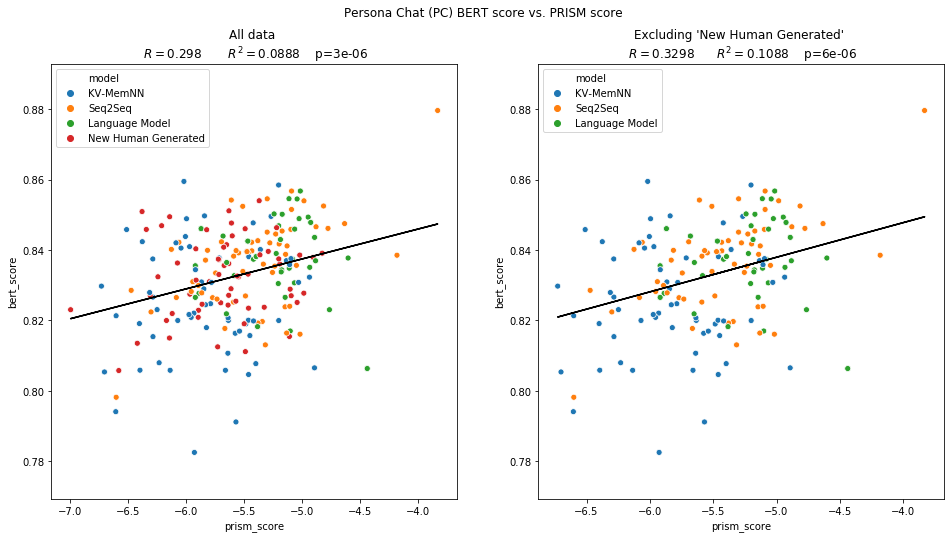

In [23]:
plot_scores(pc_df, 'prism_score', 'bert_score', regression=True)
plt.suptitle('Persona Chat (PC) BERT score vs. PRISM score')

Text(0.5, 0.98, 'Persona Chat (PC) PRISM score vs. PRISM empty score')

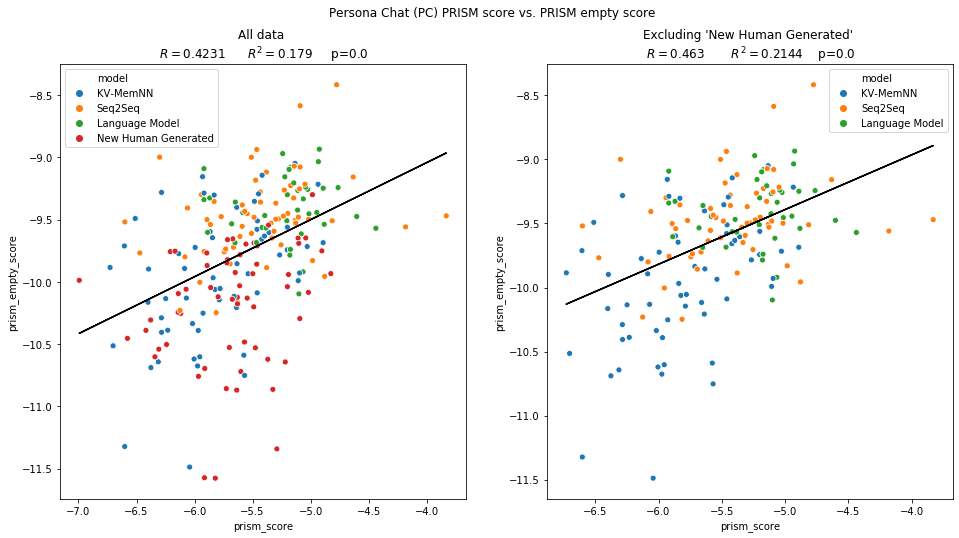

In [24]:
plot_scores(pc_df, 'prism_score', 'prism_empty_score', regression=True)
plt.suptitle('Persona Chat (PC) PRISM score vs. PRISM empty score')

Text(0.5, 0.98, 'Persona Chat (PC) BERT score vs. PRISM empty score')

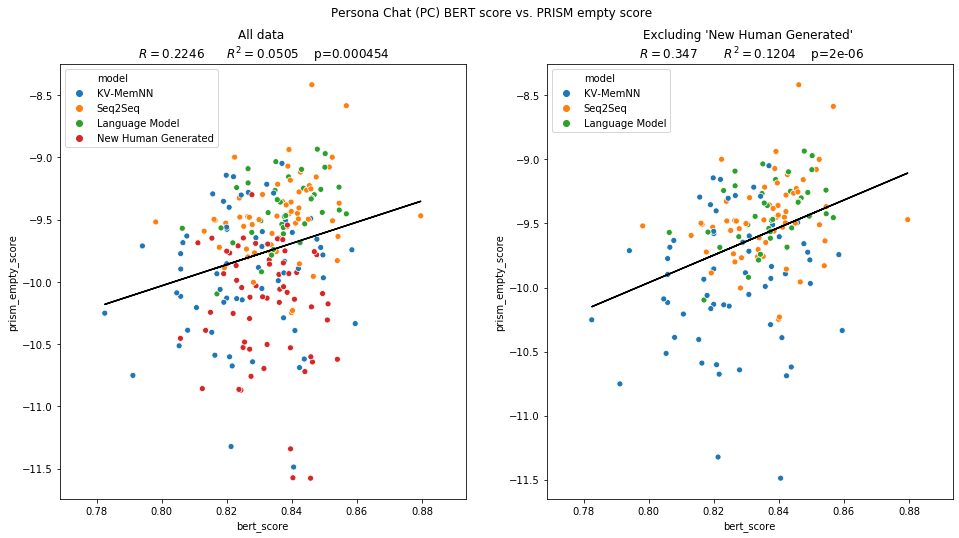

In [25]:
plot_scores(pc_df, 'bert_score', 'prism_empty_score', regression=True)
plt.suptitle('Persona Chat (PC) BERT score vs. PRISM empty score')

Text(0.5, 0.98, 'Persona Chat (PC) PRISM context score vs. BERT score')

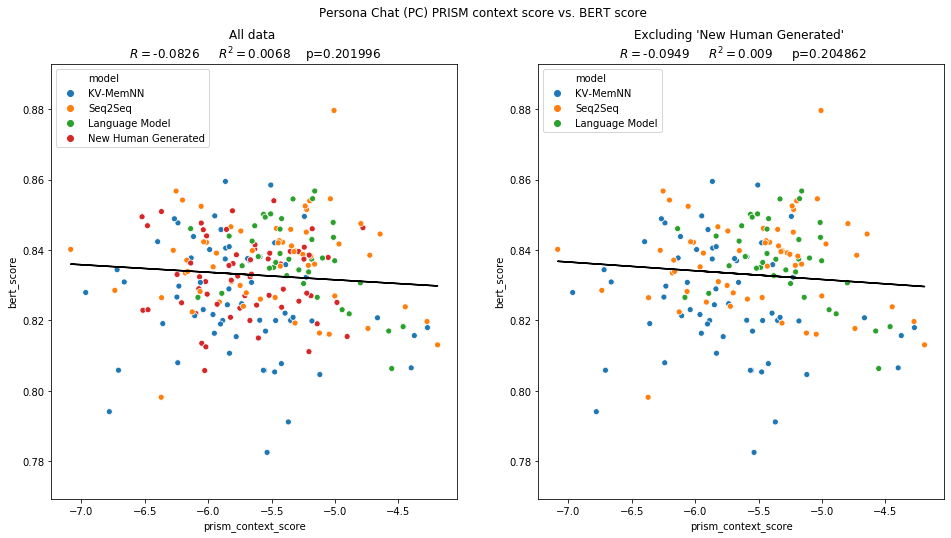

In [29]:
plot_scores(pc_df, 'prism_context_score', 'bert_score', regression=True)
plt.suptitle('Persona Chat (PC) PRISM context score vs. BERT score')

# thoughts
# *slightly* stronger correlation when excluding human generated (in line with above) but not significant
# not stat sig --> PRISM is measuring different things than BERT?
# update on BERT Score

Text(0.5, 0.98, 'Persona Chat (PC) PRISM context score vs. PRISM score')

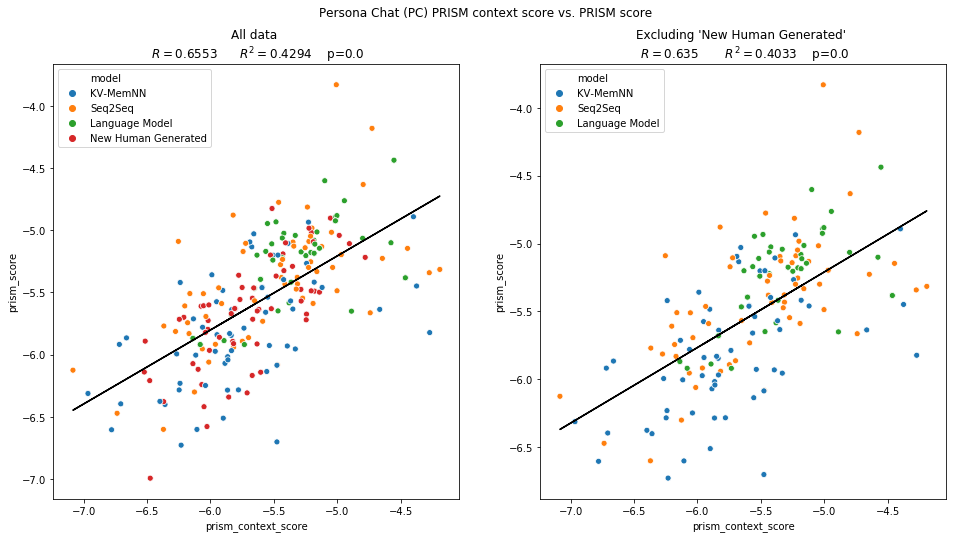

In [30]:
plot_scores(pc_df, 'prism_context_score', 'prism_score', regression=True)
plt.suptitle('Persona Chat (PC) PRISM context score vs. PRISM score')

# thoughts
# PRISM and PRISM context are measuring similar things
# removing human generated slightly hurts correlation

Text(0.5, 0.98, 'Persona Chat (PC) PRISM empty score vs. PRISM context score')

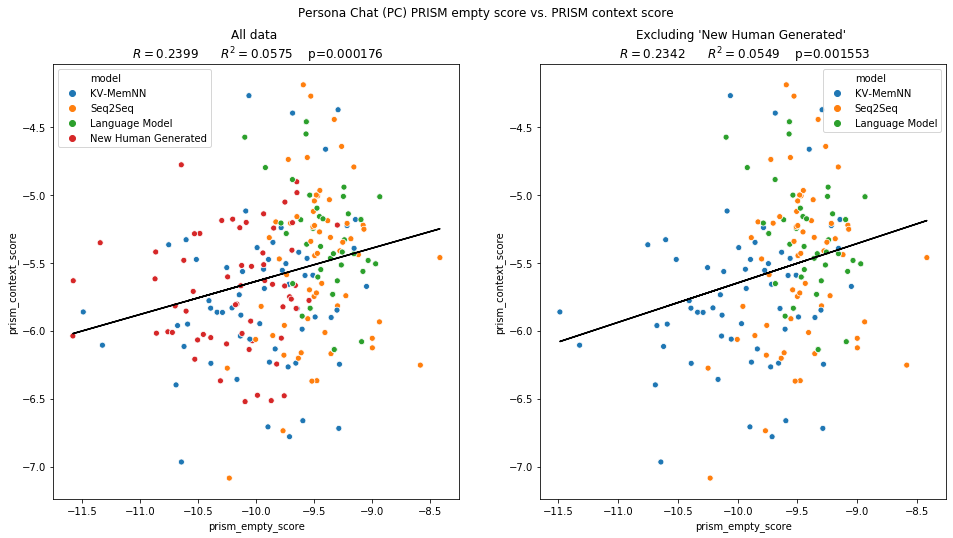

In [31]:
plot_scores(pc_df, 'prism_empty_score', 'prism_context_score', regression=True)
plt.suptitle('Persona Chat (PC) PRISM empty score vs. PRISM context score')

# thoughts
# PRISM empty vs PRISM context have stat sig correlation but the distribution is quite interesting
# seems to imply that PRISM empty is measuring something very different from PRISM and PRISM context

## Topical Chat (TC) Plots

Text(0.5, 0.98, 'Topical Chat (TC) BERT score vs. PRISM score')

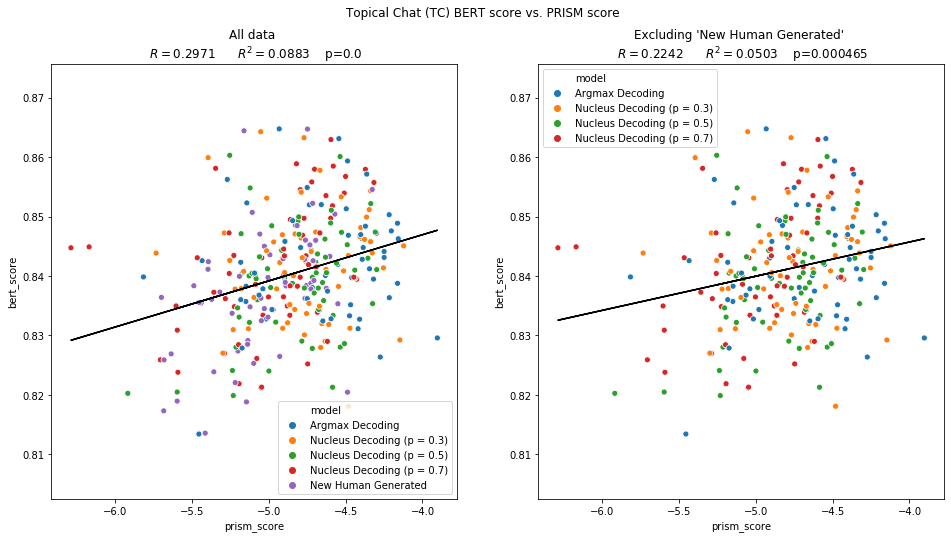

In [26]:
plot_scores(tc_df, 'prism_score', 'bert_score', regression=True)
plt.suptitle('Topical Chat (TC) BERT score vs. PRISM score')

Text(0.5, 0.98, 'Topical Chat (TC) PRISM score vs. PRISM empty score')

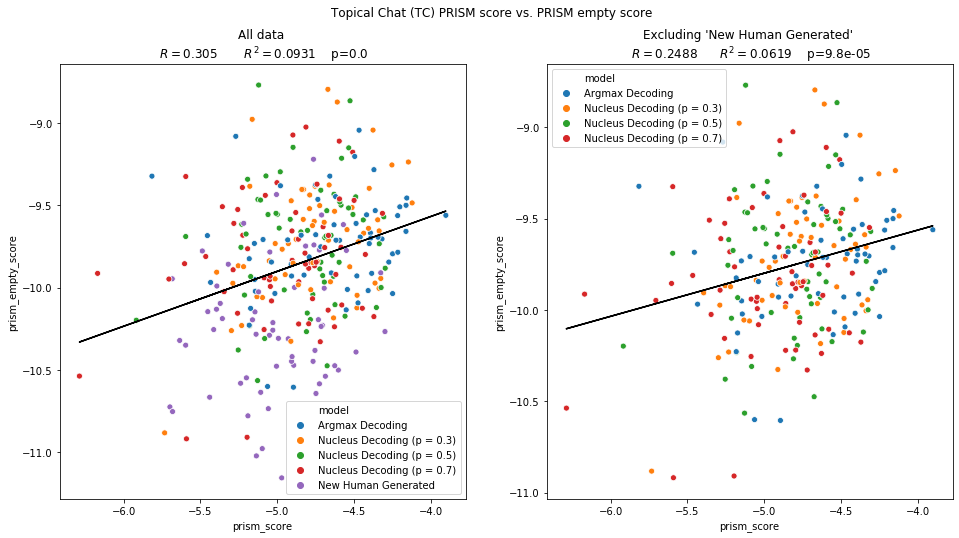

In [28]:
plot_scores(tc_df, 'prism_score', 'prism_empty_score', regression=True)
plt.suptitle('Topical Chat (TC) PRISM score vs. PRISM empty score')

Text(0.5, 0.98, 'Topical Chat (PC) BERT score vs. PRISM null score')

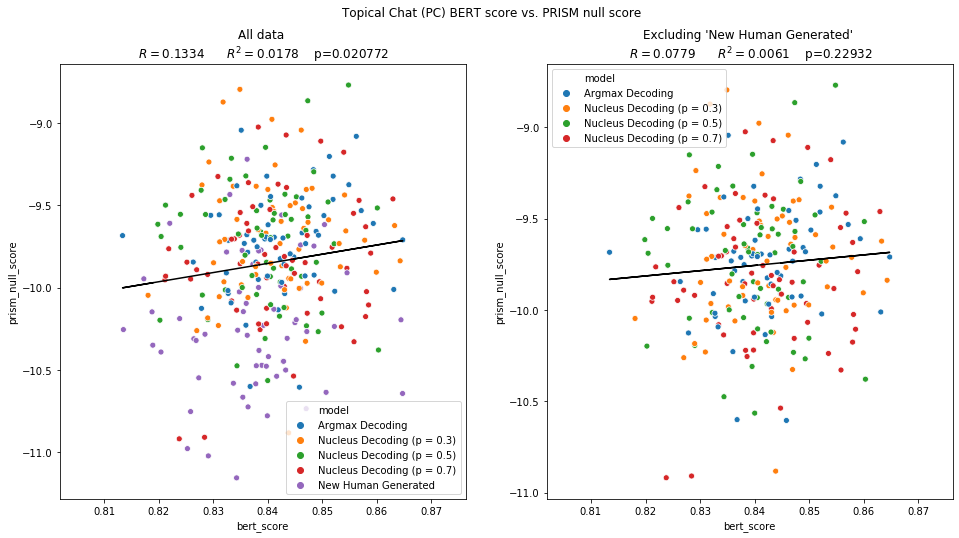

In [13]:
plot_scores(tc_df, 'bert_score', 'prism_null_score', regression=True)
plt.suptitle('Topical Chat (PC) BERT score vs. PRISM null score')

Text(0.5, 0.98, 'Topical Chat (TC) PRISM context score vs. BERT score')

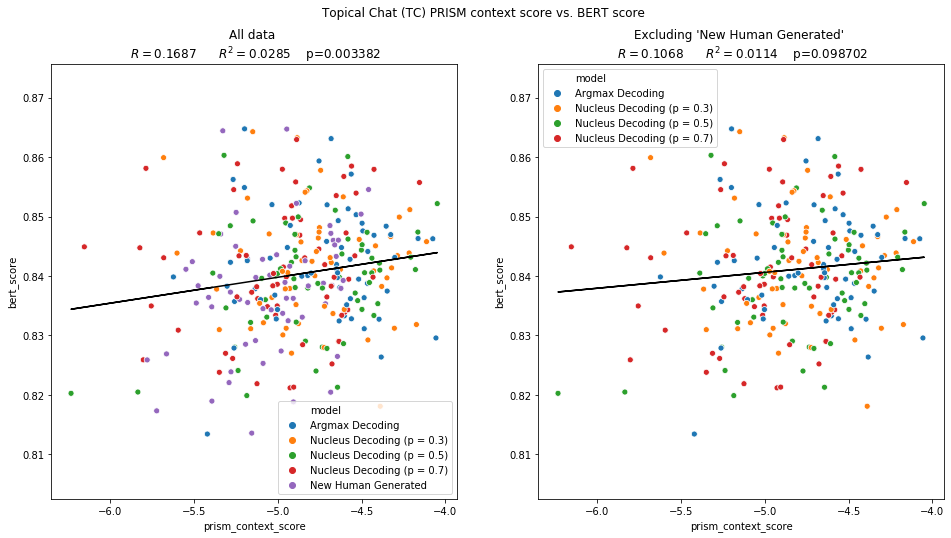

In [32]:
plot_scores(tc_df, 'prism_context_score', 'bert_score', regression=True)
plt.suptitle('Topical Chat (TC) PRISM context score vs. BERT score')

# thoughts
# excluding new human generated hurts correlation
# 

Text(0.5, 0.98, 'Topical Chat (TC) PRISM context score vs. PRISM score')

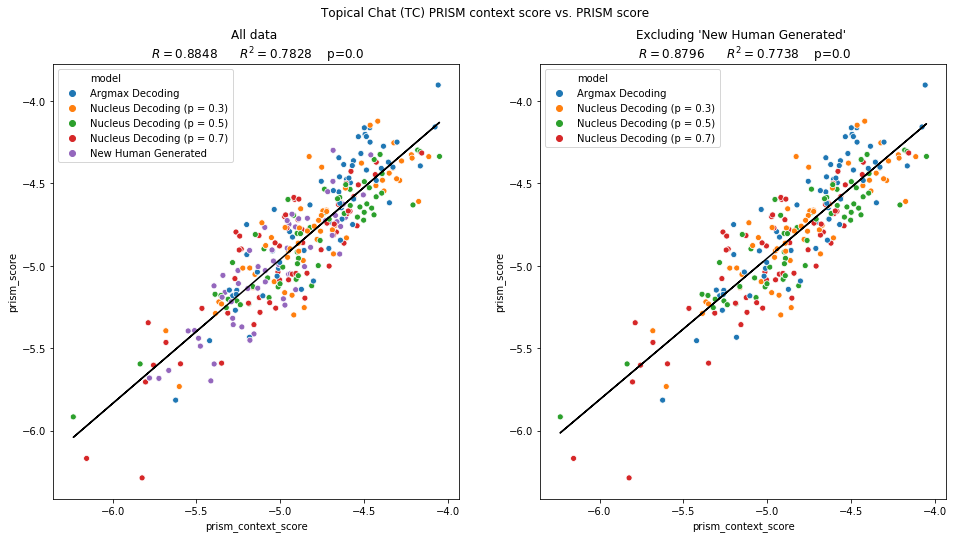

In [33]:
plot_scores(tc_df, 'prism_context_score', 'prism_score', regression=True)
plt.suptitle('Topical Chat (TC) PRISM context score vs. PRISM score')

# thoughts
# wow very highly correlated
# also suggests that PRISM and PRISM context are measuring similar things

Text(0.5, 0.98, 'Topical Chat (TC) PRISM empty score vs. PRISM context score')

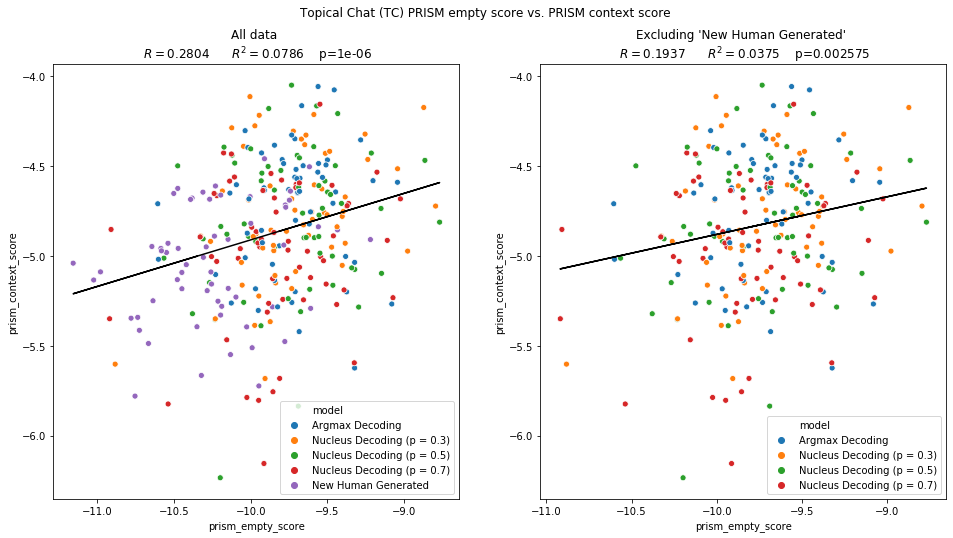

In [34]:
plot_scores(tc_df, 'prism_empty_score', 'prism_context_score', regression=True)
plt.suptitle('Topical Chat (TC) PRISM empty score vs. PRISM context score')

# thoughts
# very slightly correlated but suggests that PRISM empty and PRISM context are measuring diff things